- pandas  
  - Clean and analyze data and time series.  
  - read_csv/write_csv, filter by placeCode (HBC), groupby, rolling means, resample weekly/monthly, merge calendar, save outputs.

- numpy  
  - Numeric helpers and NaN handling.  
  - Use np.nan and simple calculations in summaries.

- matplotlib  
  - Build plots and custom overlays.  
  - Line charts, seaborn style, event bands (axvspan), custom legend (patches, Line2D).

- seaborn  
  - Clear statistical visuals.  
  - Boxplot, stripplot, heatmap to show seasonality and distributions.

In [1]:
#badminton_occupied_seasonality_analysis by He Jingping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Load raw dataset
data = pd.read_csv('../data/badminton_df.csv')
# Inspect unique codes
_ = data['placeCode'].unique()
_ = data['bookingStatus'].unique()
_ = data['bookingStatus'].value_counts()


In [2]:
# 2) Filter available and occupied slots
available_slots = data[data['bookingStatus'] == 'A']
occupied_slots = data[data['bookingStatus'].isin(['O', 'H', 'R'])].copy()

# Optional remap occupied status to 'Z'
occupied_slots['bookingStatus'] = occupied_slots['bookingStatus'].replace({'O': 'Z', 'H': 'Z', 'R': 'Z'})


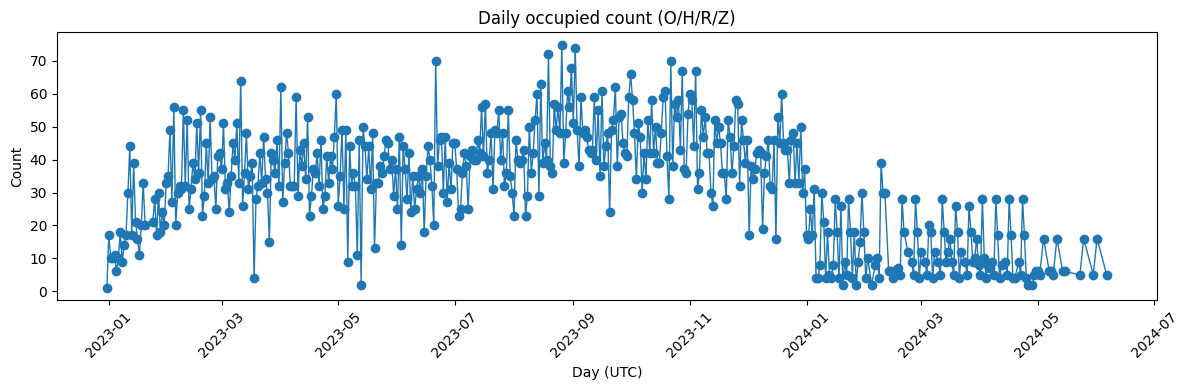

In [3]:
# 3) Build daily occupied counts
occ = occupied_slots.copy()
occ['bookingDate'] = pd.to_datetime(occ['bookingDate'], utc=True, errors='coerce')
occupied_set = {'Z', 'O', 'H', 'R'}
occ['is_occupied'] = occ['bookingStatus'].isin(occupied_set)
occ_z = occ[occ['is_occupied']].copy()
occ_z['booking_day'] = occ_z['bookingDate'].dt.date

daily_occupied = (
    occ_z.groupby('booking_day')
    .size()
    .reset_index(name='occupied_count')
    .sort_values('booking_day')
)

# Plot daily line
plt.figure(figsize=(12, 4))
plt.plot(daily_occupied['booking_day'], daily_occupied['occupied_count'], marker='o', linewidth=1)
plt.title('Daily occupied count (O/H/R/Z)')
plt.xlabel('Day (UTC)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [4]:
# 4) Normalize date column and forward-fill missing days
daily_occupied['booking_day'] = pd.to_datetime(daily_occupied['booking_day'])
daily_occupied = daily_occupied.rename(columns={'booking_day': 'Date'})
min_date, max_date = daily_occupied['Date'].min(), daily_occupied['Date'].max()
all_dates = pd.date_range(start=min_date, end=max_date, freq='D')

daily_occupied = daily_occupied.set_index('Date').reindex(all_dates)
daily_occupied['occupied_count'] = daily_occupied['occupied_count'].ffill()
daily_occupied = daily_occupied.reset_index().rename(columns={'index': 'Date'})


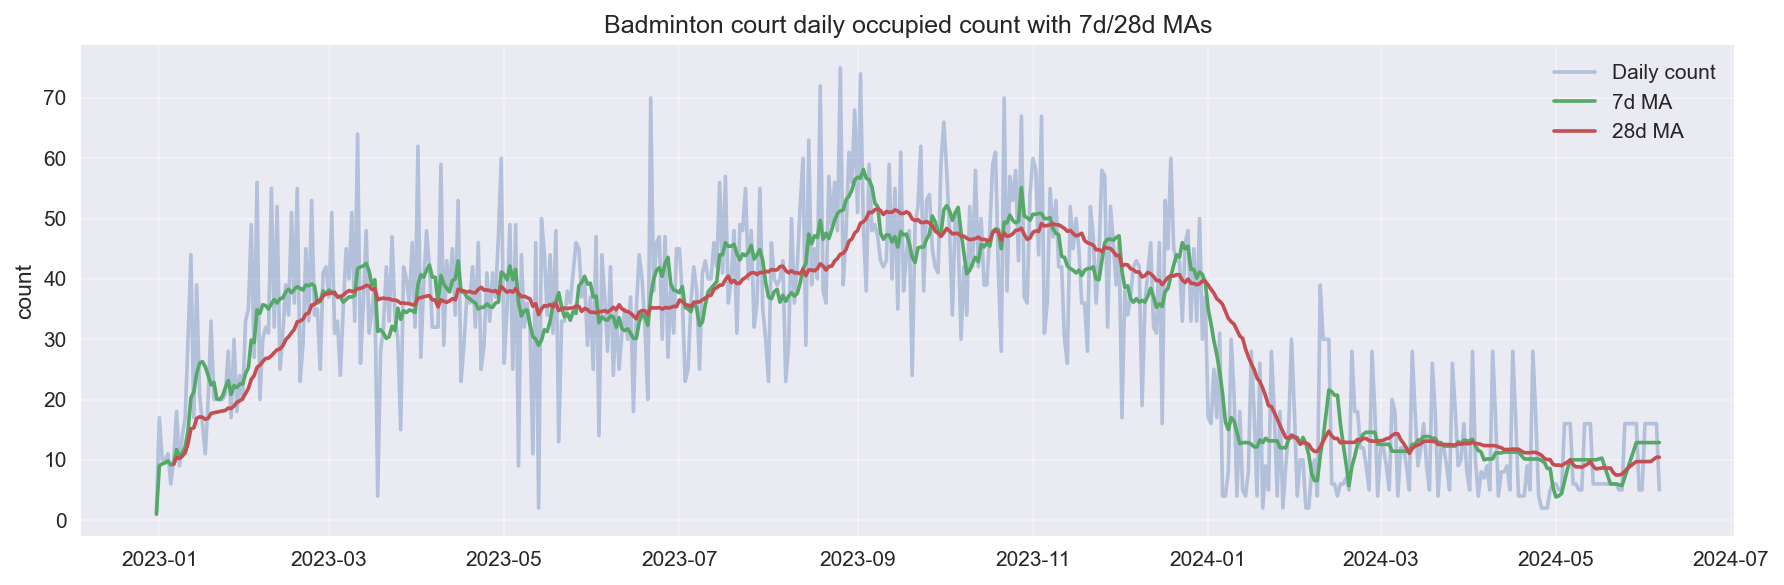

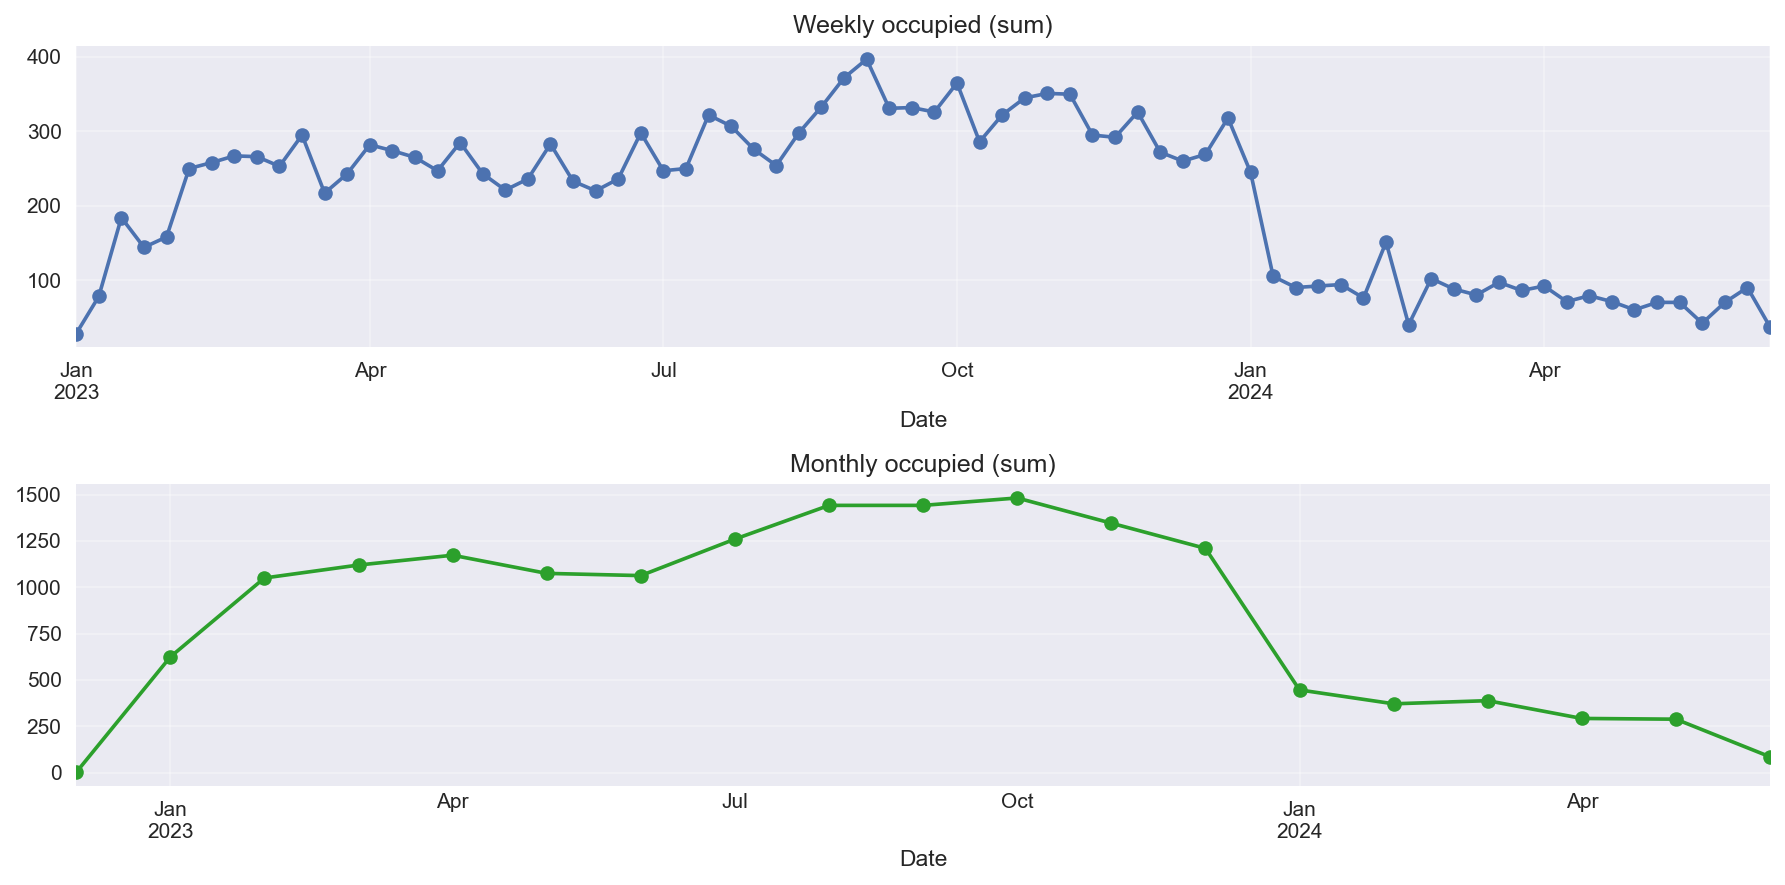

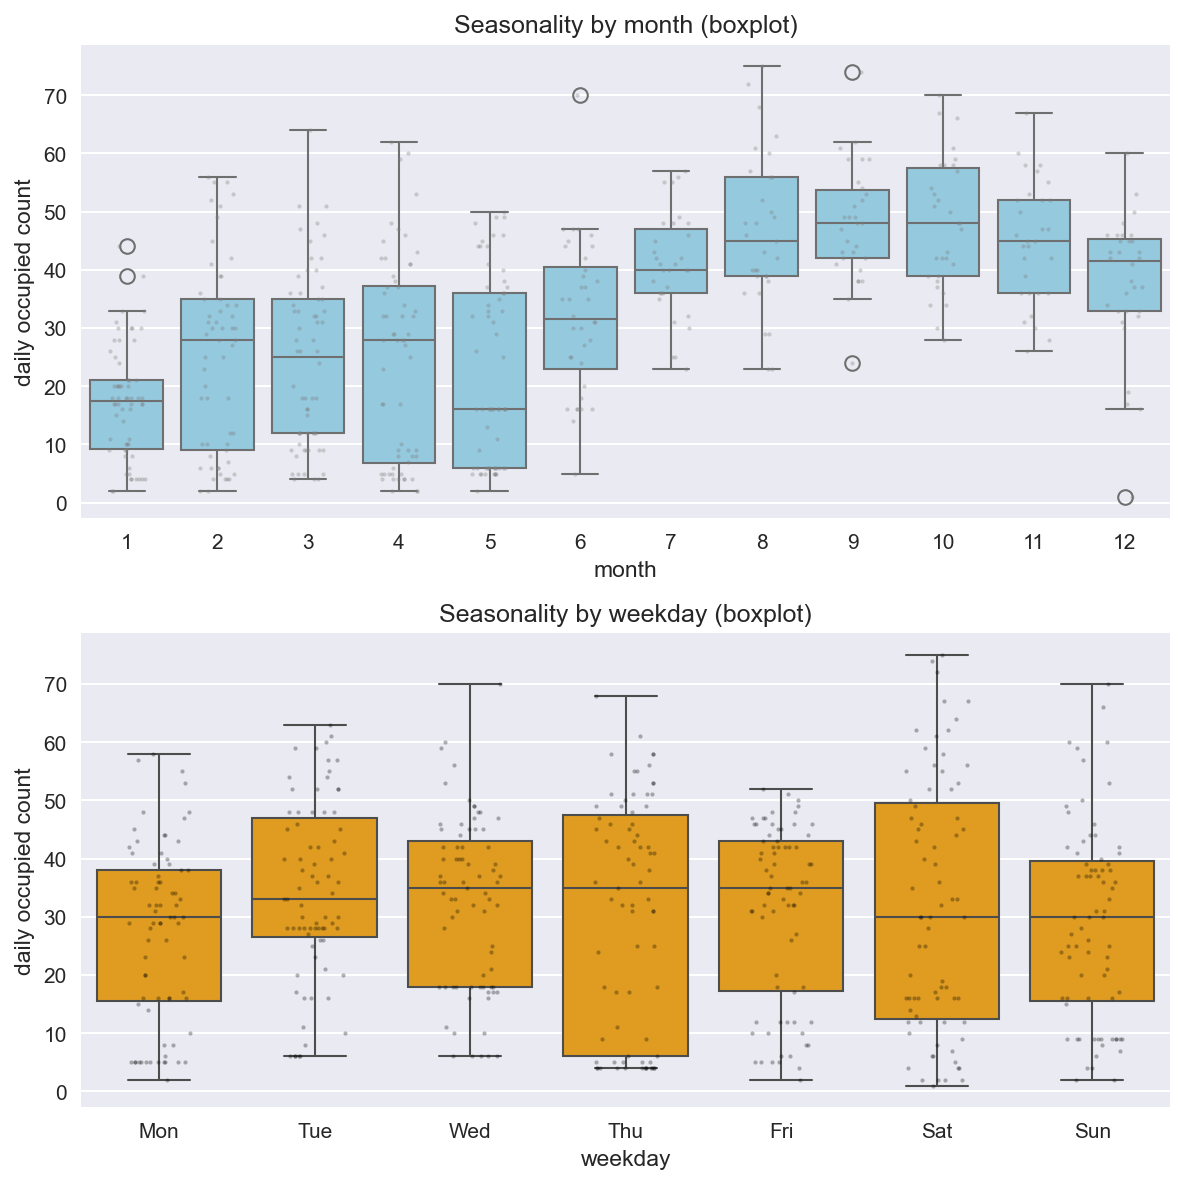

Top 10 most occupied days:
          Date  occupied_count
238 2023-08-26            75.0
245 2023-09-02            74.0
231 2023-08-19            72.0
172 2023-06-21            70.0
295 2023-10-22            70.0
243 2023-08-31            68.0
301 2023-10-28            67.0
308 2023-11-04            67.0
274 2023-10-01            66.0
70  2023-03-11            64.0


In [5]:
# 5) Simplified time series analysis
plt.style.use('seaborn-v0_8')
do = daily_occupied.copy()
do['Date'] = pd.to_datetime(do['Date']).dt.normalize()
do['occupied_count'] = pd.to_numeric(do['occupied_count'], errors='coerce')
do = do.sort_values('Date').reset_index(drop=True)

# Rolling averages (7/28 days)
do['occ_7d_ma']  = do['occupied_count'].rolling(7,  min_periods=1).mean()
do['occ_28d_ma'] = do['occupied_count'].rolling(28, min_periods=7).mean()

# Weekly and monthly aggregates (sum) with WoW/MoM
weekly  = do.set_index('Date')['occupied_count'].resample('W-MON').sum().to_frame('occ_sum')
weekly['wow'] = weekly['occ_sum'].pct_change()

monthly = do.set_index('Date')['occupied_count'].resample('ME').sum().to_frame('occ_sum')
monthly['mom'] = monthly['occ_sum'].pct_change()

# Derivative dimensions
do['month'] = do['Date'].dt.month
do['weekday'] = do['Date'].dt.weekday  # 0=Mon..6=Sun

# Visualizations: daily + MA
fig, ax = plt.subplots(figsize=(12,4), dpi=150)
ax.plot(do['Date'], do['occupied_count'], label='Daily count', alpha=0.35)
ax.plot(do['Date'], do['occ_7d_ma'], label='7d MA')
ax.plot(do['Date'], do['occ_28d_ma'], label='28d MA')
ax.set_title('Badminton court daily occupied count with 7d/28d MAs')
ax.set_ylabel('count')
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

# Weekly/Monthly aggregates
fig, axes = plt.subplots(2,1, figsize=(12,6), dpi=150)
weekly['occ_sum'].plot(ax=axes[0], marker='o')
axes[0].set_title('Weekly occupied (sum)')
axes[0].grid(alpha=0.3)
monthly['occ_sum'].plot(ax=axes[1], marker='o', color='tab:green')
axes[1].set_title('Monthly occupied (sum)')
axes[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Seasonality boxplots (month, weekday)
fig, axes = plt.subplots(2, 1, figsize=(8, 8), dpi=150)
sns.boxplot(ax=axes[0], data=do, x='month', y='occupied_count', order=list(range(1,13)), color='skyblue', showfliers=True)
sns.stripplot(ax=axes[0], data=do, x='month', y='occupied_count', order=list(range(1,13)), color='gray', size=2, alpha=0.35, jitter=0.2)
axes[0].set_title('Seasonality by month (boxplot)')
axes[0].set_xlabel('month')
axes[0].set_ylabel('daily occupied count')

weekday_order = list(range(0,7))
sns.boxplot(ax=axes[1], data=do, x='weekday', y='occupied_count', order=weekday_order, color='orange', showfliers=True)
sns.stripplot(ax=axes[1], data=do, x='weekday', y='occupied_count', order=weekday_order, color='black', size=2, alpha=0.3, jitter=0.2)
axes[1].set_title('Seasonality by weekday (boxplot)')
axes[1].set_xlabel('weekday')
axes[1].set_ylabel('daily occupied count')
axes[1].set_xticks(weekday_order)
axes[1].set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.tight_layout()
plt.show()

# Top busiest days
top_days = do.sort_values('occupied_count', ascending=False).head(10)[['Date','occupied_count']]
print('Top 10 most occupied days:')
print(top_days)


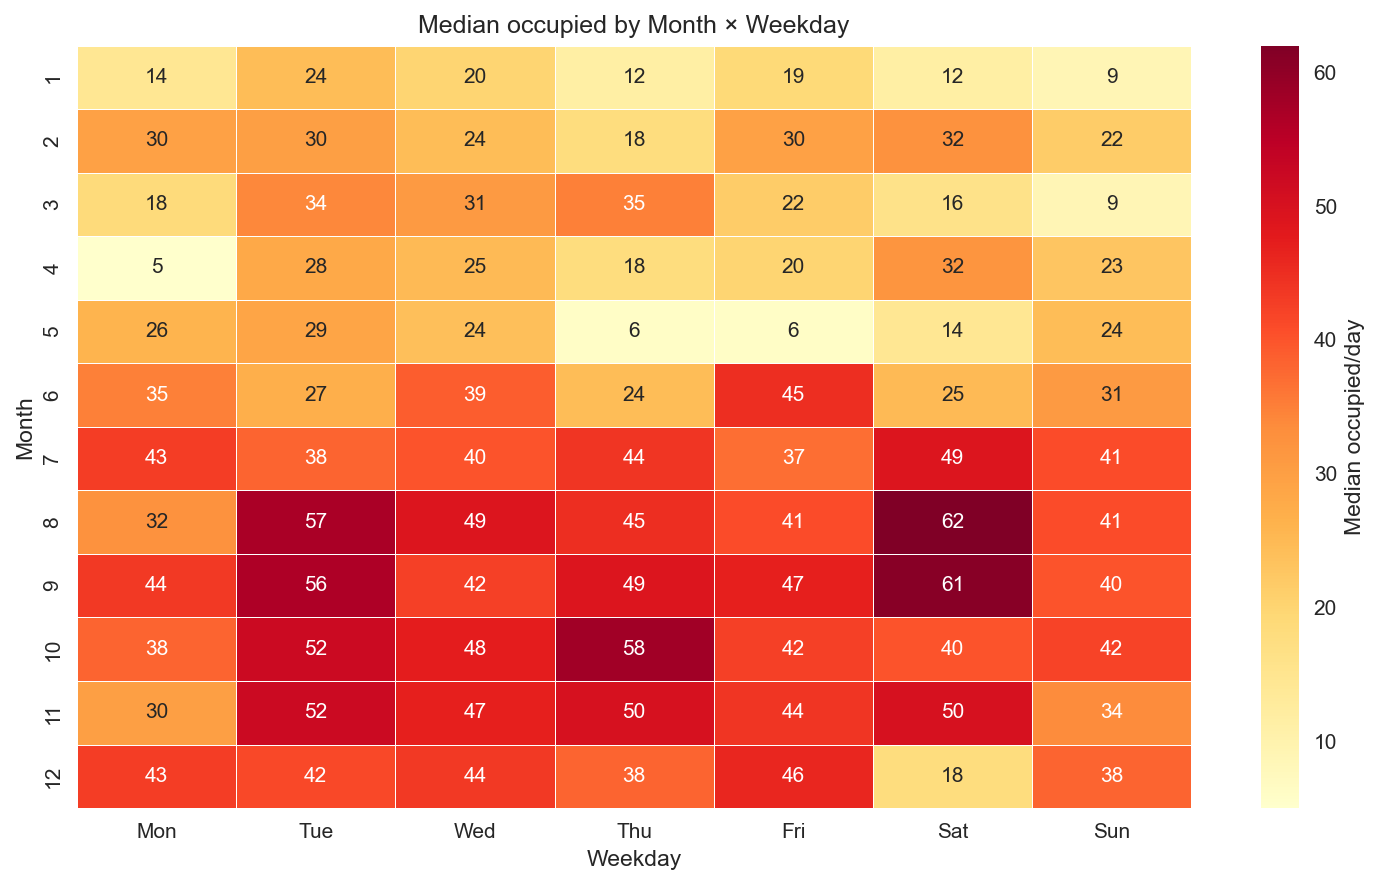

In [6]:
# 6) Month × Weekday heatmap (median)
do_hm = do.copy()
do_hm['month'] = do_hm['Date'].dt.month
hm = (
    do_hm.groupby(['month','weekday'], as_index=False)['occupied_count'].median()
    .pivot(index='month', columns='weekday', values='occupied_count')
    .reindex(index=list(range(1,13)), columns=list(range(0,7)))
)
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
sns.heatmap(hm, ax=ax, cmap='YlOrRd', annot=True, fmt='.0f',
            cbar_kws={'label': 'Median occupied/day'}, linewidths=0.3, linecolor='white')
ax.set_title('Median occupied by Month × Weekday')
ax.set_xlabel('Weekday'); ax.set_ylabel('Month')
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.tight_layout(); plt.show()


In [7]:
# 7) Academic calendar load and merge
calender_2024 = pd.read_csv('../data/um_academic_calendar_2023_24.csv')
calender_2023 = pd.read_csv('../data/um_academic_calendar_2022_23.csv')
calender = pd.concat([calender_2023, calender_2024], ignore_index=True)


/var/folders/fq/3pmzyx3s60l0sjm0lfcpdfhh0000gn/T/ipykernel_19391/704720784.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df, x='event_type', y='occupied_count', order=plot_cats, showfliers=False, palette='Set2', ax=ax, width=0.5)
/var/folders/fq/3pmzyx3s60l0sjm0lfcpdfhh0000gn/T/ipykernel_19391/704720784.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{cat}\n(n={counts.get(cat, 0)})' for cat in plot_cats])


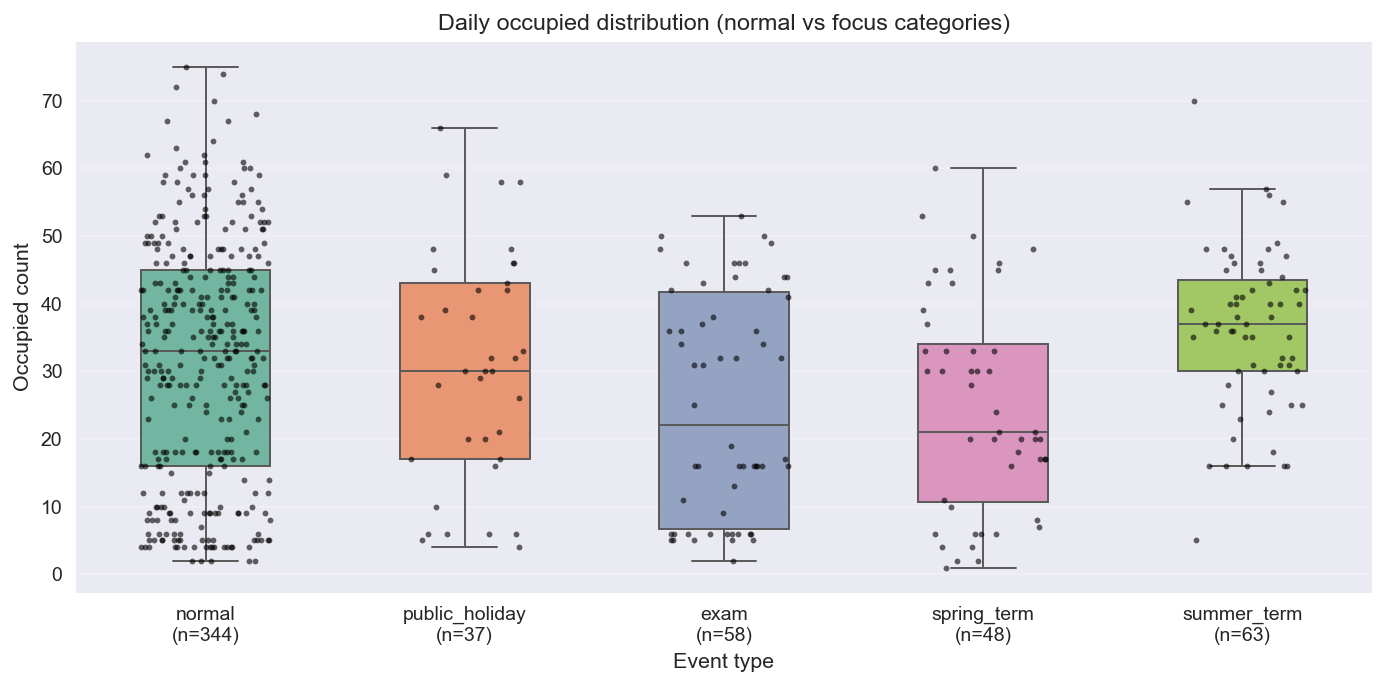


Event type impact summary (focus categories):
                days  median       mean  mean_vs_normal_%
event_type                                               
summer_term       63    37.0  36.158730         14.938118
normal           344    33.0  31.459302          0.000000
public_holiday    37    30.0  30.810811         -2.061366
exam              58    22.0  25.206897        -19.874585
spring_term       48    21.0  24.750000        -21.326927


In [8]:
# 8) Calendar impact preprocessing
cal = calender.copy()
cal.columns = [str(c).strip().lower() for c in cal.columns]
alias_map = {'tart_date': 'start_date', 'start date': 'start_date', 'end date': 'end_date', 'events': 'event'}
for k, v in alias_map.items():
    if k in cal.columns and v not in cal.columns:
        cal.rename(columns={k: v}, inplace=True)

required = {'start_date','end_date','event'}
if required - set(cal.columns):
    raise ValueError(f'Missing calendar columns: {required - set(cal.columns)}')

if 'type' not in cal.columns:
    cal['type'] = None

if 'needs_confirm' in cal.columns:
    cal['needs_confirm'] = (
        cal['needs_confirm'].astype(str).str.strip().str.lower()
        .map({'true': True, 'false': False, '1': True, '0': False})
        .fillna(False)
    )

cal['start_date'] = pd.to_datetime(cal['start_date'], errors='coerce')
cal['end_date']   = pd.to_datetime(cal['end_date'],   errors='coerce')
cal.loc[cal['end_date'].isna() & cal['start_date'].notna(), 'end_date'] = cal['start_date']
cal['event_subtype'] = cal['type'].astype(str).str.strip().str.lower()

focus_set = {'public_holiday','exam','spring_term','summer_term'}
holiday_kw = ['festival','day','national day','holiday']
exam_kw = ['exam','examination','contingency','final exam']

def infer_type(row):
    t = str(row.get('type','')).strip().lower()
    e = str(row.get('event','')).strip().lower()
    if t in focus_set: return t
    if any(k in e for k in exam_kw): return 'exam'
    if any(k in e for k in holiday_kw): return 'public_holiday'
    if 'spring' in e and 'term' in e: return 'spring_term'
    if 'summer' in e and 'term' in e: return 'summer_term'
    return 'other'

cal['event'] = cal['event'].astype(str).str.strip()
cal['type_std'] = cal.apply(infer_type, axis=1)
cal = cal[cal['start_date'].notna() & cal['end_date'].notna()].copy().sort_values('start_date')

rows = []
for _, r in cal.iterrows():
    for d in pd.date_range(r['start_date'], r['end_date'], freq='D'):
        rows.append({
            'Date': d.normalize(),
            'event': r['event'],
            'type_std': r['type_std'],
            'event_subtype': r['event_subtype'],
            'needs_confirm': r.get('needs_confirm', False)
        })
cal_days = pd.DataFrame(rows)

# Merge calendar to daily occupied
impact_df = do.merge(cal_days, on='Date', how='left')
impact_df['event_type'] = impact_df['type_std'].fillna('normal')
impact_df.loc[~impact_df['event_type'].isin(list(focus_set)), 'event_type'] = impact_df['event_type'].where(impact_df['event_type']=='normal', 'other')

# Boxplot by event_type
plot_cats = ['normal','public_holiday','exam','spring_term','summer_term']
plot_df = impact_df[impact_df['event_type'].isin(plot_cats)].copy()
counts = plot_df['event_type'].value_counts().reindex(plot_cats).fillna(0).astype(int)

fig, ax = plt.subplots(figsize=(10,5), dpi=140)
sns.boxplot(data=plot_df, x='event_type', y='occupied_count', order=plot_cats, showfliers=False, palette='Set2', ax=ax, width=0.5)
sns.stripplot(data=plot_df, x='event_type', y='occupied_count', order=plot_cats, ax=ax, color='black', size=3, alpha=0.6, jitter=0.25)
ax.set_title('Daily occupied distribution (normal vs focus categories)')
ax.set_xlabel('Event type'); ax.set_ylabel('Occupied count')
ax.set_xticklabels([f'{cat}\n(n={counts.get(cat, 0)})' for cat in plot_cats])
ax.grid(axis='y', alpha=0.2)
plt.tight_layout(); plt.show()

# Event impact summary
summary = (impact_df[impact_df['event_type'].isin(plot_cats)]
           .groupby('event_type')['occupied_count']
           .agg(['count','median','mean'])
           .rename(columns={'count':'days'}))
if 'normal' in summary.index:
    base_mean = float(summary.loc['normal','mean']) if pd.notna(summary.loc['normal','mean']) else np.nan
    summary['mean_vs_normal_%'] = (summary['mean']/base_mean - 1.0)*100 if pd.notna(base_mean) and base_mean != 0 else np.nan
print('\nEvent type impact summary (focus categories):')
print(summary.sort_values('mean_vs_normal_%', ascending=False))


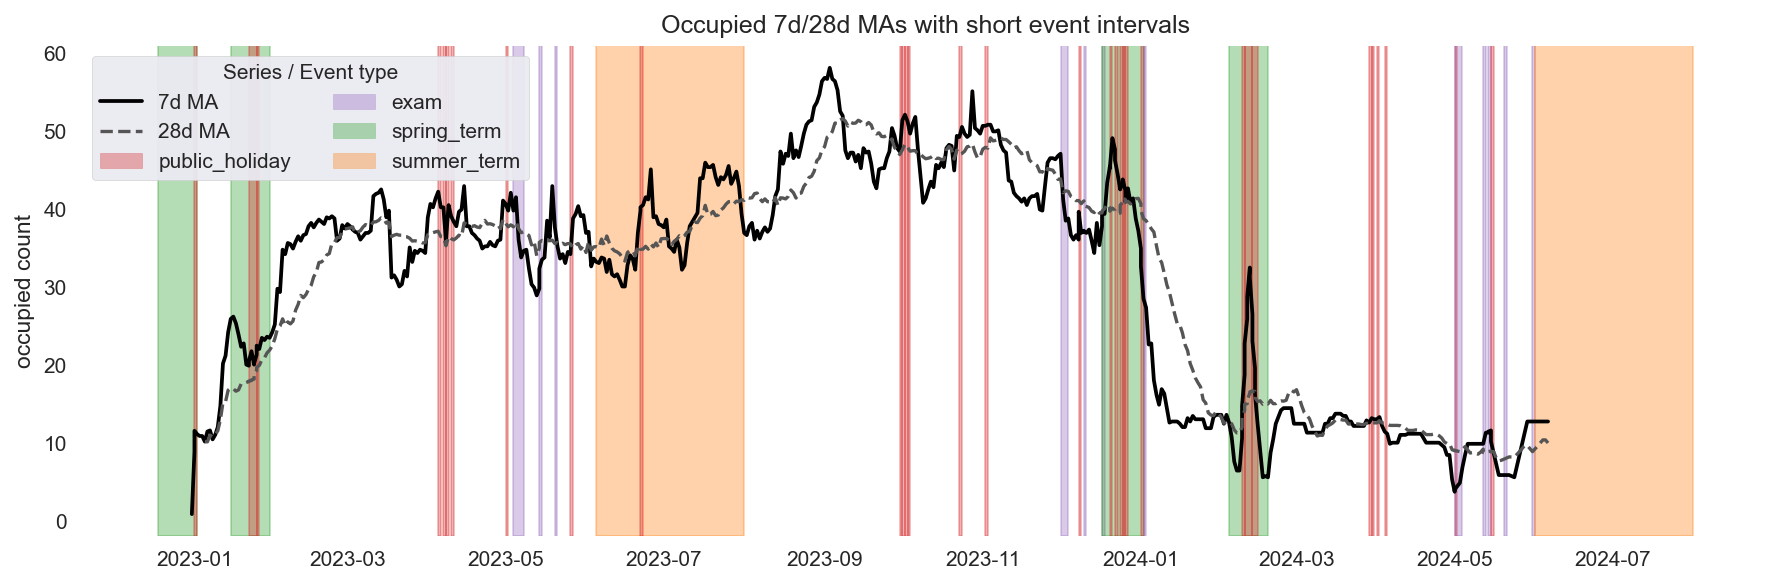

In [9]:
# 9) Overlay short events on time series (bands) + 7/28 MA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np

# 1) Filter events (public_holiday/exam ≤10 days; spring_term/summer_term unlimited)
short_events = cal.copy()
short_events['span_days'] = (short_events['end_date'] - short_events['start_date']).dt.days + 1
mask_short_focus = short_events['type_std'].isin(['public_holiday', 'exam']) & (short_events['span_days'] <= 10)
mask_terms = short_events['type_std'].isin(['spring_term', 'summer_term'])
short_events = short_events[(mask_short_focus | mask_terms) & short_events['type_std'].isin(focus_set)]

# 2) Palette
palette = {
    'public_holiday': '#d62728',  # red
    'exam':           '#9467bd',  # purple
    'spring_term':    '#2ca02c',  # green
    'summer_term':    '#ff7f0e',  # orange
}

# 3) Compute 7/28-day moving averages
do_ma = impact_df[['Date', 'occupied_count']].dropna().copy()
do_ma['Date'] = pd.to_datetime(do_ma['Date']).dt.normalize()
do_ma = do_ma.sort_values('Date').reset_index(drop=True)
do_ma['occ_7d_ma']  = do_ma['occupied_count'].rolling(7,  min_periods=1).mean()
do_ma['occ_28d_ma'] = do_ma['occupied_count'].rolling(28, min_periods=7).mean()

# 4) Plot: event bands + 7d/28d MA only (no daily line)
fig, ax = plt.subplots(figsize=(12, 4), dpi=150)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Event bands
for _, r in short_events.iterrows():
    st, ed = r['start_date'], r['end_date']
    if st > do_ma['Date'].max() or ed < do_ma['Date'].min():
        continue
    color = palette.get(r['type_std'], 'plum')
    ax.axvspan(st, ed + pd.Timedelta(days=1),
               facecolor=color, edgecolor=color,
               alpha=0.35, lw=0.8, zorder=1)

# MA only
ax.plot(do_ma['Date'], do_ma['occ_7d_ma'],  color='black',    lw=1.8, label='7d MA', zorder=4)
ax.plot(do_ma['Date'], do_ma['occ_28d_ma'], color='#555555',  lw=1.6, ls='--', label='28d MA', zorder=4)

ax.set_title('Occupied 7d/28d MAs with short event intervals')
ax.set_ylabel('occupied count')
ax.grid(alpha=0.25)

# Legend (no Daily)
order = ['public_holiday', 'exam', 'spring_term', 'summer_term']
patch_handles = [mpatches.Patch(facecolor=palette[c], edgecolor=palette[c], alpha=0.35, label=c) for c in order]
line_ma7   = Line2D([0], [0], color='black',    lw=1.8, label='7d MA')
line_ma28  = Line2D([0], [0], color='#555555',  lw=1.6, ls='--', label='28d MA')
ax.legend(handles=[line_ma7, line_ma28, *patch_handles],
          title='Series / Event type', loc='upper left', frameon=True, framealpha=0.95, ncol=2)

plt.tight_layout()
plt.show()

# 5) Summary stats (median-based; baseline = normal median)
plot_cats = ['normal','public_holiday','exam','spring_term','summer_term']
summary = (impact_df[impact_df['event_type'].isin(plot_cats)]
           .groupby('event_type')['occupied_count']
           .agg(days='count', median='median'))

if 'normal' in summary.index:
    base_med = float(summary.loc['normal', 'median']) if pd.notna(summary.loc['normal', 'median']) else np.nan
    if pd.notna(base_med) and base_med != 0:
        summary['median_vs_normal_%'] = (summary['median'] / base_med - 1.0) * 100
    else:
        summary['median_vs_normal_%'] = np.nan
else:
    summary['median_vs_normal_%'] = np.nan
